In [1]:
import gym
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# from tensorflow import keras
# from keras.layers import Dense
import pandas.core.frame
from google.colab import drive
from typing import Tuple
from dateutil import parser
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [122]:
def stock_price_format(n):
    if n < 0:
        return "- # {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

exchange_rate = 70


class ExchangeEnv:
    current_index = 0

    def __init__(self, start_index=0, actions=None, model_name="trading_env", stock_name="oil_brent", deposit_env=1000):
        if actions is None:
            actions = {0: "buy", 1: "sell", 2: "hold"}
        self.action_space = len(actions)
        self.model_name = model_name
        self.stock_name = stock_name
        self.inventory = []
        self.inventory_evals = [deposit_env]
        self.actions_buffer = []
        self.stocks_actions = []
        self.deposit_env = deposit_env

        self.current_index = start_index
        self.data, self.data_slice, self.delta, self.delta_slice = self.dataset_loader()
        self.state_space = len(self.delta.iloc[self.current_index])
        self.data_size = len(self.data)
        self.total_profit = 0

    def reset(self, start_index=0):
        self.current_index = start_index
        self.inventory = []
        self.inventory_evals = [self.deposit_env]
        self.stocks_actions = []

    # DATA

    def previous_state(self):
        if self.current_index - 1 >= 0:
            return self.data_slice.iloc[self.current_index - 1]
        else:
            return -1

    def previous_price(self):
        return self.previous_state()['Close']

    def previous_state_batch(self):
        if self.current_index - 1 >= 0:
            result = []
            for i in range(max(0, self.current_index - 5), self.current_index - 1):
                for column in self.data_slice.columns:
                    result.append(self.data_slice.iloc[i][column])
            return result
        else:
            return -1

    def current_state(self):
        if self.current_index < self.data_size:
            return self.data_slice.iloc[self.current_index]
        else:
            return -1

    def current_price(self):
        return self.current_state()['Close']

    def current_state_batch(self):
        if self.current_index < self.data_size:
            result = []
            for i in range(max(0, self.current_index - 4), self.current_index):
                for column in self.data_slice.columns:
                    result.append(self.data_slice.iloc[i][column])
            return result
        else:
            return -1

    def next_state(self):
        if self.current_index + 1 < self.data_size:
            return self.data_slice.iloc[self.current_index + 1]
        else:
            return -1

    def next_state_batch(self):
        if self.current_index + 1 < self.data_size:
            result = []
            for i in range(max(0, self.current_index - 3), self.current_index + 1):
                for column in self.data_slice.columns:
                    result.append(self.data_slice.iloc[i][column])
            return result
        else:
            return -1

    def last_actions(self, number):
        begin_index = len(self.actions_buffer) - number \
            if len(self.actions_buffer) >= number \
            else 0
        return self.actions_buffer[begin_index:]

    def clear_stocks_actions(self):
        self.stocks_actions = []

    def get_next_state(self, action, deposit_state, finish_index) -> Tuple[dict, bool, int]:
        current_price = self.current_price()
        fee = 0

        if action == 0: # buy
            tup = current_price, self.data.iloc[self.current_index]["Date"]
            self.inventory.append(tup)
            deposit_state -= (current_price + fee)
            self.stocks_actions.append((self.current_index, current_price, 'buy'))
            self.actions_buffer.append(0)

        elif action == 1: # sell
            buy_price, buy_date_string = self.inventory.pop(0)

            deposit_state += current_price - fee
            self.stocks_actions.append((self.current_index, current_price, 'sell', current_price - buy_price))
            self.actions_buffer.append(1)

        else: # hold
            self.actions_buffer.append(2)

        if self.current_index + 1 < finish_index:
            next_state = self.next_state_batch()
        else:
            next_state = self.current_state_batch()

        # if self.current_index + 1 < finish_index:
        #     next_state = self.next_state()
        # else:
        #     next_state = self.current_state()

        is_done = self.current_index == finish_index

        self.inventory_evals.append(deposit_state + current_price * len(self.inventory))
        self.current_index += 1

        return next_state, is_done, deposit_state

    # DELTA

    # PREVIOUS

    def previous_state_delta(self):
        if self.current_index - 1 >= 0:
            return self.delta_slice.iloc[self.current_index - 1]
        else:
            return -1

    def previous_price_delta(self):
        return self.previous_state()['Close']

    def previous_state_batch_delta(self):
        if self.current_index - 1 >= 0:
            result = []
            for i in range(max(0, self.current_index - 5), self.current_index - 1):
                for column in self.delta_slice.columns:
                    result.append(self.delta_slice.iloc[i][column])
            return result
        else:
            return -1

    # CURRENT

    def current_state_delta(self):
        if self.current_index < self.data_size:
            return self.delta_slice.iloc[self.current_index]
        else:
            return -1

    def current_price_delta(self):
        return self.current_state()['Close']

    def current_state_batch_delta(self):
        if self.current_index < self.data_size:
            result = []
            for i in range(max(0, self.current_index - 4), self.current_index):
                for column in self.delta_slice.columns:
                    result.append(self.delta_slice.iloc[i][column])
            return result
        else:
            return -1

    # NEXT

    def next_state_delta(self):
        if self.current_index + 1 < self.data_size:
            return self.delta_slice.iloc[self.current_index + 1]
        else:
            return -1

    def next_state_batch_delta(self):
        if self.current_index + 1 < self.data_size:
            result = []
            for i in range(max(0, self.current_index - 3), self.current_index + 1):
                for column in self.delta_slice.columns:
                    result.append(self.delta_slice.iloc[i][column])
            return result
        else:
            return -1

    def get_next_state_delta(self, action, deposit_state, finish_index) -> Tuple[dict, bool, int]:
        current_price = self.current_price()
        fee = 0

        if action == 0: # buy
            tup = current_price, self.delta.iloc[self.current_index]["Date"]
            self.inventory.append(tup)
            deposit_state -= (current_price + fee)
            self.stocks_actions.append((self.current_index, current_price, 'buy'))
            self.actions_buffer.append(0)

        elif action == 1: # sell
            buy_price, buy_date_string = self.inventory.pop(0)

            deposit_state += current_price - fee
            self.stocks_actions.append((self.current_index, current_price, 'sell', current_price - buy_price))
            self.actions_buffer.append(1)

        else: # hold
            self.actions_buffer.append(2)

        if self.current_index + 1 < finish_index:
            next_state = self.next_state_batch_delta()
        else:
            next_state = self.current_state_batch_delta()

        # if self.current_index + 1 < finish_index:
        #     next_state = self.next_state_delta()
        # else:
        #     next_state = self.current_state_delta()

        is_done = self.current_index == finish_index

        self.inventory_evals.append(deposit_state + current_price * len(self.inventory))
        self.current_index += 1

        return next_state, is_done, deposit_state

    def dataset_loader(self):
        data = pd.read_csv(self.stock_name + '_data.csv')
        data.insert(6, "Day", [parser.parse(date).weekday() for date in data["Date"]], True)

        for i in range(0, data.shape[0]):
            for col in data.columns.values.tolist():
                if col != 'Date' and col != 'Change %' and col != "Day":
                    data.at[i, col] = data.iloc[i][col] * exchange_rate

        data_slice = data.copy().loc[:, "Open":"Day"]

        delta = data.copy()

        for i in range(0, data.shape[0]):
            for col in data.columns.values.tolist():
                if col != 'Date' and col != 'Change %' and col != "Day":
                    value = 0 if i == 0 else data.iloc[i][col] - data.iloc[i - 1][col]
                    delta.at[i, col] = value
        
        delta_slice = delta.copy().loc[:, "Open":"Day"]

        return data, data_slice, delta, delta_slice
  

**EXPERIENCE REPLAY**

In [3]:
class ExpReplay():
    def __init__(self, e_max=15000, e_min=100):
        self._max = e_max # maximum number of experiences
        self._min = e_min # minimum number of experiences for training
        self.exp = {'state':[], 'action':[], 'reward':[], 'next_state':[], 'done':[]} # total experiences the Agent stored
        
    def get_max(self):
        """return the maximum number of experiences"""
        return self._max
    
    def get_min(self):
        """return the minimum number of experiences"""
        return self._min
    
    def get_num(self):
        """return the curren number of experiences"""
        return len(self.exp['state'])
    
    def get_batch(self, batch_size=64):
        """random choose a batch of experiences for training"""
        idx = np.random.choice(self.get_num(), size=batch_size, replace=False)
        state = np.array([self.exp['state'][i] for i in idx])
        action = [self.exp['action'][i] for i in idx]
        reward = [self.exp['reward'][i] for i in idx]
        next_state = np.array([self.exp['next_state'][i] for i in idx])
        day = np.array([self.exp['day'][i] for i in idx])
        return state, action, reward, next_state, done
        
    def add(self, state, action, reward, next_state, done):
        """remove the oldest experience if the meomory is full"""
        if self.get_num()>self.get_max():
            del self.exp['state'][0]
            del self.exp['action'][0]
            del self.exp['reward'][0]
            del self.exp['next_state'][0]
            del self.exp['done'][0]
        """add single experience"""
        self.exp['state'].append(state)
        self.exp['action'].append(action)
        self.exp['reward'].append(reward)
        self.exp['next_state'].append(next_state)
        self.exp['done'].append(done)

**Model building**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features=state_space, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=action_space)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        return out

class LSTM_1(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_1, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 4
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [30]:
def get_action(env, q_values, deposit_session, epsilon=0.5):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)

    {0: "buy", 1: "sell", 2: "hold"}
    """

    q_values = q_values.detach().numpy()
    price = env.current_price()
    able_actions_qvalues = []
    able_actions = []
    if deposit_session >= price:
        able_actions_qvalues.append((q_values[0][0], 0))
        able_actions.append(0)
    if len(env.inventory) > 0:
        able_actions_qvalues.append((q_values[0][1], 1))
        able_actions.append(1)
    able_actions_qvalues.append((q_values[0][2], 2))
    able_actions.append(2)

    # print("actions: ", able_actions)
    # print("qvalues: ", able_actions_qvalues)

    # print("q", q_values)
    # print("deposit_session", deposit_session, "price", price, "inv", env.inventory)
    coin = np.random.rand()
    if coin > epsilon:
        # print(able_actions_qvalues)
        action = max(able_actions_qvalues)[1]
    else:
        action = np.random.choice(able_actions)

    # print("choose = ", action)
    # print()

    return int(action)

In [6]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot


def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1 - cond) * x_2)


def compute_td_loss(env, network, predicted_qvalues, states, actions, rewards, next_states, is_done, gamma=0.8, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)  # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32)  # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.float32)  # shape: [batch_size]

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(
        predicted_qvalues * to_one_hot(actions, env.action_space), dim=1)

    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=-1)[0]
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss


In [7]:
# def count_reward(env, action, deposit) -> int:
#     current_price = env.current_price()
#     previous_price = env.previous_price()

#     deposit_previous = deposit + env.previous_price() * len(env.inventory)
#     deposit_current = deposit + env.current_price() * len(env.inventory)
#     reward = deposit_current - deposit_previous

#     if action == 0: # buy
#         env.actions_buffer.append(0)

#     elif action == 1: # sell
#         env.actions_buffer.append(1)

#     else: # hold
#         reward = -1
#         env.actions_buffer.append(2)
    
#     return reward

def count_pnl(env, action):
    deposit_previous = env.inventory_evals[-2]
    deposit_current = env.inventory_evals[-1]
    pnl = (deposit_current - deposit_previous) / 1000 * 100

    return pnl

def count_reward(env, action, deposit=1000) -> int:
    # reward = count_pnl(env, action)
    current_price = env.current_price()
    reward = 0
    if action == 0: # buy
        reward = 1
        env.actions_buffer.append(0)

    elif action == 1: # sell
        reward = env.stocks_actions[-1][3] * 3
        env.actions_buffer.append(1)

    else: # hold
        last = env.last_actions(10)
        holds = 0
        for i in last:
            if i == 2:
                holds += 1
        if holds >= 5:
            reward += -5

        env.actions_buffer.append(2)

    return reward

In [124]:
def generate_session(env, network_A, opt_A, is_double, deposit_session, data_max_size=3000, epsilon=0.0, start_index=0, train=False, network_B=None, opt_B=None):
    total_reward = 0
    env.reset(start_index)
    # state = env.current_state()
    state = env.current_state_batch_delta()
    deposits = [deposit_session]
    deposits_evaluation = [deposit_session]

    for t in range(data_max_size):
        state_tensor = torch.tensor([state], dtype=torch.float32)
        next_state = None
        done = False

        if is_double and train:
            if np.random.randint(2) == 0:
                # next_state, done, deposit_session, reward, opt_A = session(env, network_A, network_B, opt_A, deposit_session, state, epsilon, start_index, data_max_size, train)
                q_values_A = network_A(state_tensor)
 
                action_A = get_action(env, q_values_A, deposit_session, epsilon)
                next_state, done, deposit_session = env.get_next_state_delta(action=action_A, 
                                                                             deposit_state=deposit_session,
                                                                             finish_index=start_index + data_max_size - 1)
                
                reward = count_reward(env, action_A)
 
                if train:
                    model_train(env, network_B, opt_A, q_values_A, state, action_A, reward, next_state, done)
            else:
                q_values_B = network_B(state_tensor)
 
                action_B = get_action(env, q_values_B, deposit_session, epsilon)
                next_state, done, deposit_session = env.get_next_state_delta(action=action_B, 
                                                                             deposit_state=deposit_session,
                                                                             finish_index=start_index + data_max_size - 1)
                
                reward = count_reward(env, action_B)
 
                if train:
                    model_train(env, network_A, opt_B, q_values_B, state, action_B, reward, next_state, done)
                # next_state, done, deposit_session, reward, opt_B = session(env, network_B, network_A, opt_B, deposit_session, state, epsilon, start_index, data_max_size, train)
        else:
            q_values_A = network_A(state_tensor)
 
            action_A = get_action(env, q_values_A, deposit_session, epsilon)
            # print("choose action = ", action_A)
            next_state, done, deposit_session = env.get_next_state_delta(action=action_A, 
                                                                         deposit_state=deposit_session,
                                                                         finish_index=start_index + data_max_size - 1)
            
            reward = count_reward(env, action_A)
 
            if train:
                model_train(env, network_A, opt_A, q_values_A, state, action_A, reward, next_state, done)
            # next_state, done, deposit_session, reward, opt_A = session(env, network_A, network_A, opt_A, deposit_session, state, epsilon, start_index, data_max_size, train)

        deposit_session_value = deposit_session + env.previous_price() * len(env.inventory)

        deposits_evaluation.append(deposit_session_value)
        deposits.append(deposit_session)

        total_reward += reward
        state = next_state

        if done:
            current_price = env.previous_price()
            for stock in env.inventory:
                reward = current_price - stock[0]
                total_reward += reward
                deposit_session += current_price
                deposits.append(deposit_session)
                env.stocks_actions.append((env.current_index - 1, current_price, 'sell', reward))
            break

    return total_reward, deposit_session, deposits, deposits_evaluation, network_A, opt_A, network_B, opt_B

In [10]:
# def session(env, network_A, network_B, opt_A, deposit_session, state, epsilon, start_index, data_max_size, train):
#     state_tensor = torch.tensor([[state]], dtype=torch.float32)
#     q_values_A = network_A(state_tensor)

#     action_A = get_action(env, q_values_A, deposit_session, epsilon=epsilon)

#     next_state, done, deposit_session = env.get_next_state(action=action_A, 
#                                                            deposit_state=deposit_session,
#                                                            finish_index=start_index + data_max_size - 1)
#     reward = count_reward(env, action_A, deposit_session)

#     if train:
#         opt_A.zero_grad()
#         compute_td_loss(env, network_B, q_values_A, [[state]], [action_A], [reward], [[next_state]], [done]).backward()
#         opt_A.step()
#         # model_train(env, network_B, opt_A, q_values_A, state, action_A, reward, next_state, done)
    
#     return next_state, done, deposit_session, reward, opt_A

In [113]:
def model_train(env, network, opt, q_values, state, action, reward, next_state, done, is_double_dqn=False):
    opt.zero_grad()
    compute_td_loss(env, network, q_values, [state], [action], [reward], [next_state], [done]).backward()
    opt.step()

In [98]:
def trade_train(env, start, is_double, network_A_train, opt_A_train, network_B_par, opt_B_par):
    network_B_train = network_B_par
    opt_B_train = opt_B_par

    epsilon = 0.5
    deposit = 1000 * exchange_rate

    data_size = 259
    session_dynamics = []
    deposit_dynamics = []

    for epoch in range(150):
        session_rewards = []
        session_deposits = []
        min_dep = 1e5
        max_dep = -1
        for session in range(0, 10):
            r, d, deposits, deposits_evaluation, network_A_train, opt_A_train, network_B_train, opt_B_train = generate_session(env=env, 
                                                                                                                               network_A=network_A_train,
                                                                                                                               opt_A=opt_A_train,
                                                                                                                               is_double=is_double,
                                                                                                                               deposit_session=deposit,
                                                                                                                               data_max_size=data_size, 
                                                                                                                               epsilon=epsilon,
                                                                                                                               start_index=start,
                                                                                                                               train=True,
                                                                                                                               network_B=network_B_train,
                                                                                                                               opt_B=opt_B_train)
            session_rewards.append(r)
            session_deposits.append(d)
            min_dep = min(min_dep, min(deposits_evaluation))
            max_dep = max(max_dep, max(deposits_evaluation))
        print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(
            epoch, np.mean(session_rewards), epsilon))
        print("epoch #{}\tmean deposit = {:.3f}\tepsilon = {:.3f}".format(
            epoch, np.mean(session_deposits), epsilon))
        print("min deposit eval = ", min_dep)
        print("max deposit eval = ", max_dep)
        print("final deposits = ", session_deposits)
        session_dynamics.append(np.mean(session_rewards))
        deposit_dynamics.append(np.mean(session_deposits))

        epsilon *= 0.97
        # assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    return session_dynamics, deposit_dynamics, network_A_train, opt_A_train, network_B_train, opt_B_train

In [96]:
def trade_test(env, start, network_A_test, opt_A_test, network_B_test, opt_B_test):
    network_B = None
    opt_B = None

    epsilon = 0
    deposit = 1000 * exchange_rate

    data_size = 259

    r, d, _, deposits_evaluation, _, _, _, _ = generate_session(env=env, 
                                                                network_A=network_A_test,
                                                                opt_A=opt_A_test,
                                                                is_double=False,
                                                                deposit_session=deposit, 
                                                                data_max_size=data_size, 
                                                                epsilon=epsilon, 
                                                                start_index=start, 
                                                                train=False,
                                                                network_B=network_B_test,
                                                                opt_B=opt_B_test)
    print("final #{}\t reward = {:.3f}\tepsilon = {:.3f}".format(
        0, r, 0))
    print("final #{}\t deposit = {:.3f}\tepsilon = {:.3f}".format(
        0, d, 0))
    print(env_test.stocks_actions)
    print(deposits_evaluation)
    visualize(env_test, start_index=start, end_index=start + data_size)

    return deposits_evaluation

In [50]:
def visualize_main(env, start_index, end_index, show_dates=False, show_months=True):
    data = env.data
    
    if show_dates:
        x = [data.iloc[i]["Date"] for i in range(start_index, end_index)]
        plt.plot(x, data['Close'][start_index:end_index])
        if show_months:
            ticks = []
            added = False
            for i in range(0, len(x)):
                if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
                    ticks.append(x[i])
                    added = True
                elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
                    added = False
        else: # show years
            ticks = []
            added = False
            for i in range(0, len(x)):
                if x[i][:3] == "Jan" and not added:
                    print(x[i][:3] + " " + x[i][-4:], " ", i)
                    ticks.append(x[i])
                    added = True
                elif x[i][:3] == "Feb":
                    added = False

        plt.xticks(ticks, rotation=40)
    else:
        x = [i for i in range(start_index, end_index)]
        plt.plot(x, data['Close'][start_index:end_index])

    plt.xlabel("date")
    plt.ylabel("price")
    plt.title("Brent Oil price")

def visualize(env, start_index, end_index, show_points1=False, show_points2=False, show_months=True):
    plt.figure(figsize=(16, 5))
    visualize_main(env, start_index, end_index, True, show_months)
    plt.show()

    if show_points1:
        plt.figure(figsize=(16, 5))
        visualize_main(env, start_index, end_index, False, show_months)
        for value in env.stocks_actions:
            if value[2] == 'buy':
                plt.scatter(value[0], value[1], color='green')
            elif value[2] == 'sell':
                plt.scatter(value[0], value[1], color='red')
        plt.show()

    if show_points2:
        plt.figure(figsize=(16, 5))
        visualize_main(env, start_index, end_index, False, show_months)
        for value in env.stocks_actions:
            if value[2] == 'sell' and value[3] > 0:
                plt.scatter(value[0], value[1], color='blue')
            elif value[2] == 'sell' and value[3] < 0:
                plt.scatter(value[0], value[1], color='brown')
        plt.show()

# **ИСПЫТАНИЕ 1**

## **ТРЕНИРОВКА**

In [90]:
train_start_index = 2271
env_train = ExchangeEnv(start_index=train_start_index)

network_A_train_1 = DQN(6, 3)
opt_A_train_1 = torch.optim.Adam(network_A_train_1.parameters(), lr=3 * 10**-4)

network_B_train_1 = None
opt_B_train_1 = None

session_dynamics_1, deposit_dynamics_1, network_A_res_1, opt_A_res_1, network_B_res_1, opt_B_res_1 = trade_train(env=env_train, 
                                                                                                                 start=train_start_index,
                                                                                                                 is_double=False,
                                                                                                                 network_A_train=network_A_train_1, 
                                                                                                                 opt_A_train=opt_A_train_1, 
                                                                                                                 network_B_par=network_B_train_1, 
                                                                                                                 opt_B_par=opt_B_train_1)

epoch #0	mean reward = 8919.470	epsilon = 0.500
epoch #0	mean deposit = 73102.470	epsilon = 0.500
min deposit eval =  59967.59999999999
max deposit eval =  82688.9
final deposits =  [75817.70000000003, 66953.6, 67852.39999999997, 74951.79999999999, 75880.0, 75653.9, 72207.80000000002, 73728.19999999995, 74182.49999999997, 73796.8]
epoch #1	mean reward = 11206.250	epsilon = 0.475
epoch #1	mean deposit = 74054.190	epsilon = 0.475
min deposit eval =  61316.5
max deposit eval =  81688.6
final deposits =  [72207.10000000003, 69190.8, 77676.90000000001, 72051.69999999995, 72107.69999999995, 74267.19999999998, 73518.9, 77606.89999999992, 74429.6, 77485.10000000005]
epoch #2	mean reward = 6650.900	epsilon = 0.451
epoch #2	mean deposit = 72670.780	epsilon = 0.451
min deposit eval =  59442.6
max deposit eval =  80945.19999999997
final deposits =  [71569.40000000001, 67866.40000000002, 69887.99999999997, 74519.90000000005, 71873.9, 70272.30000000003, 78556.80000000002, 71442.69999999995, 76466.59

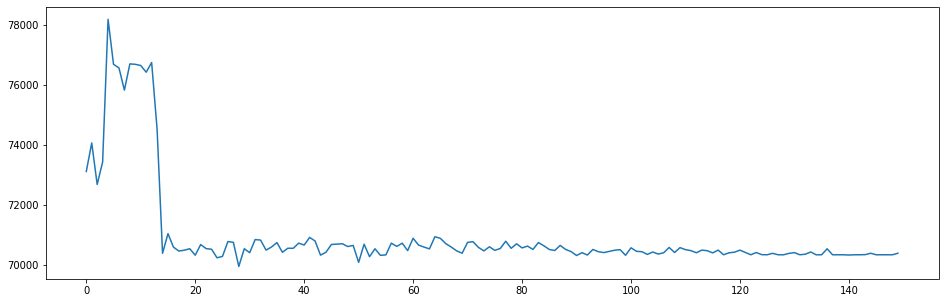

In [91]:
plt.figure(figsize=(16, 5))
plt.plot([i for i in range(0, len(deposit_dynamics_1))], deposit_dynamics_1)
plt.show()

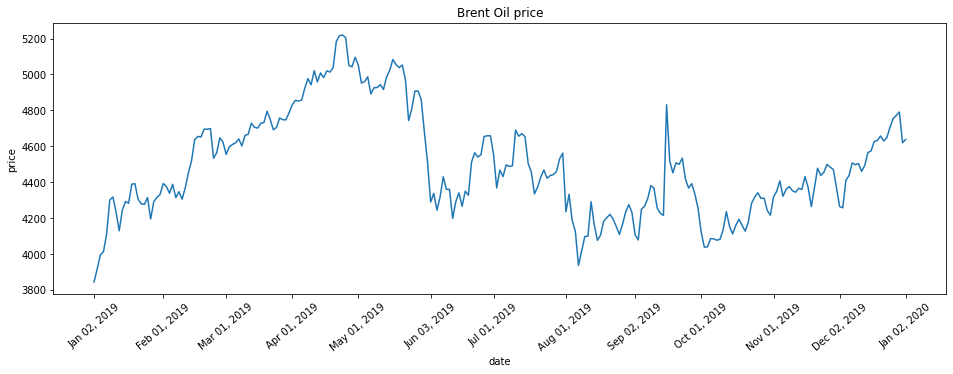

In [92]:
visualize(env_train, 2271, 2271 + 259, False, False, True)

## **ТЕСТИРОВАНИЕ**

**2017**

final #0	 reward = 3376.600	epsilon = 0.000
final #0	 deposit = 71082.200	epsilon = 0.000
[(1756, 3882.9, 'buy'), (1757, 3952.2000000000003, 'sell', 69.30000000000018), (1758, 3982.3, 'buy'), (1759, 3997.0, 'sell', 14.699999999999818), (1760, 3845.7999999999997, 'buy'), (1761, 3754.8, 'sell', -90.99999999999955), (1762, 3857.0, 'buy'), (1763, 3920.7, 'sell', 63.69999999999982), (1764, 3881.5, 'buy'), (1765, 3910.2, 'sell', 28.699999999999818), (1766, 3882.9, 'buy'), (1767, 3774.4, 'sell', -108.5), (1768, 3791.2, 'buy'), (1769, 3884.3, 'sell', 93.10000000000036), (1770, 3866.1, 'buy'), (1771, 3880.7999999999997, 'sell', 14.699999999999818), (1772, 3855.6, 'buy'), (1773, 3936.8, 'sell', 81.20000000000027), (1774, 3886.4, 'buy'), (1775, 3866.1, 'sell', -20.300000000000182), (1776, 3899.0, 'buy'), (1777, 3976.0, 'sell', 77.0), (1778, 3959.2000000000003, 'buy'), (1779, 3976.7000000000003, 'sell', 17.5), (1780, 3900.4, 'buy'), (1781, 3853.5, 'sell', -46.90000000000009), (1782, 3858.399999999

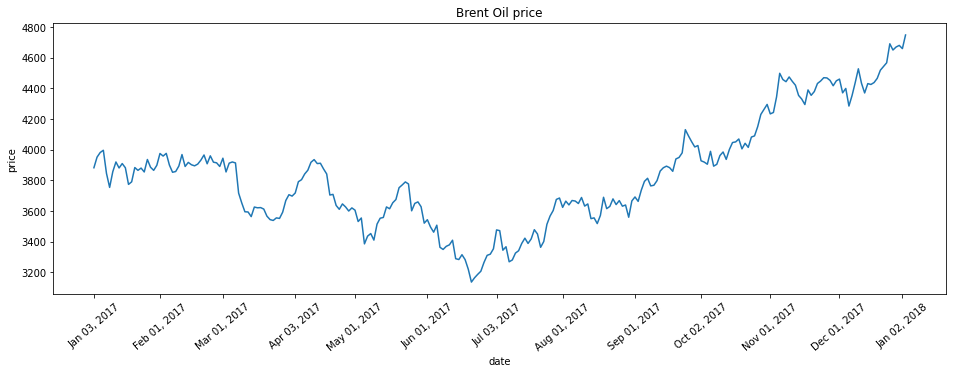

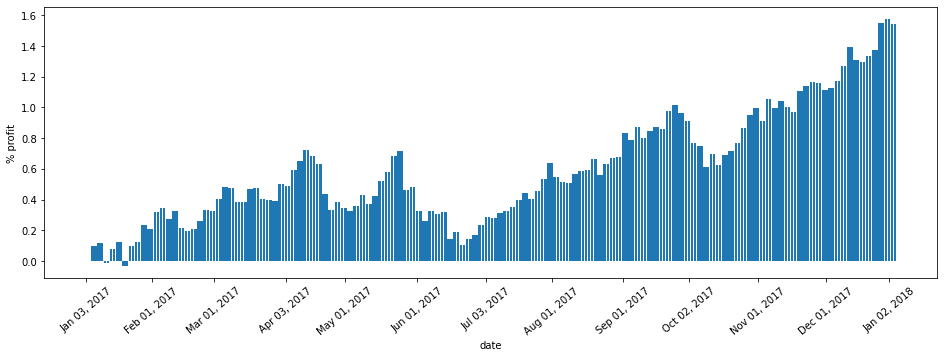

In [103]:
# 2017
test_start_index = 1756
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_1_2017 = trade_test(env_test, test_start_index, network_A_res_1, opt_A_res_1, network_B_res_1, opt_B_res_1)
deposits_evaluation_1_2017 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_1_2017]

x = [env_test.data.iloc[i]["Date"] for i in range(1756, 1756 + len(deposits_evaluation_1_2017))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_1_2017)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

**2015**

final #0	 reward = -5859.200	epsilon = 0.000
final #0	 deposit = 68003.600	epsilon = 0.000
[(1240, 3949.4, 'buy'), (1241, 3717.7, 'sell', -231.70000000000027), (1242, 3577.0, 'buy'), (1243, 3580.5, 'sell', 3.5), (1244, 3567.2000000000003, 'buy'), (1245, 3507.7, 'sell', -59.500000000000455), (1246, 3320.1, 'buy'), (1247, 3261.3, 'sell', -58.79999999999973), (1248, 3408.2999999999997, 'buy'), (1249, 3336.9, 'sell', -71.39999999999964), (1250, 3511.9, 'buy'), (1251, 3418.8, 'sell', -93.09999999999991), (1252, 3359.3, 'buy'), (1253, 3432.1, 'sell', 72.79999999999973), (1254, 3396.4, 'buy'), (1255, 3415.2999999999997, 'sell', 18.899999999999636), (1256, 3371.2, 'buy'), (1257, 3472.0, 'sell', 100.80000000000018), (1258, 3392.9, 'buy'), (1259, 3439.1000000000004, 'sell', 46.20000000000027), (1260, 3709.3, 'buy'), (1261, 3832.5, 'sell', 123.19999999999982), (1262, 4053.7, 'buy'), (1263, 3791.2, 'sell', -262.5), (1264, 3959.9, 'buy'), (1265, 4046.0, 'sell', 86.09999999999991), (1266, 4083.8, 'b

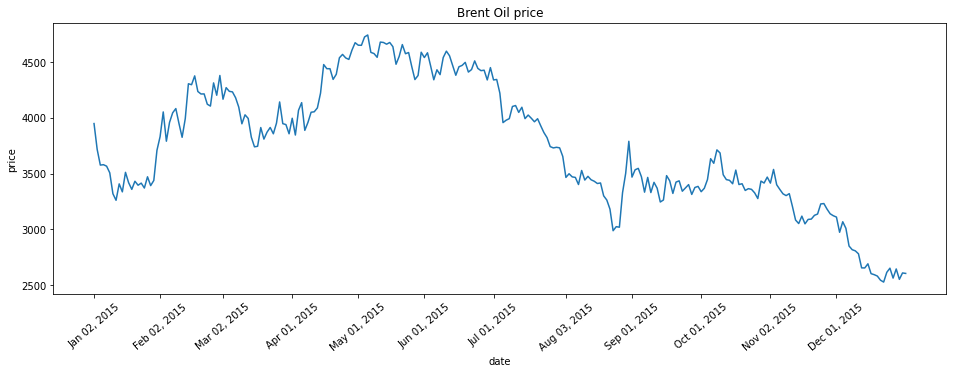

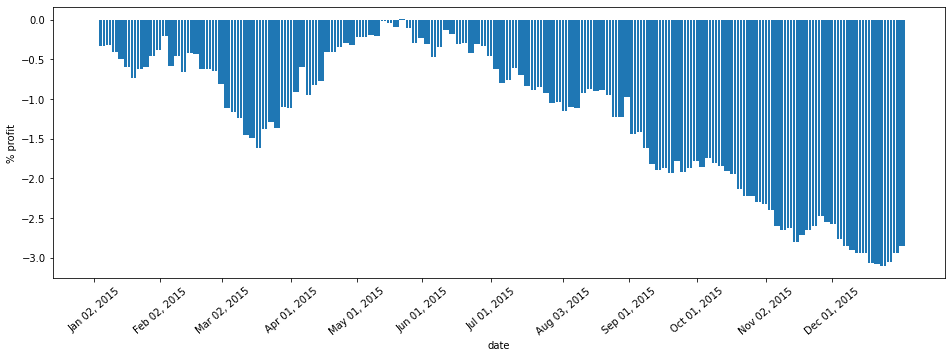

In [105]:
# 2015
test_start_index = 1240
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_1_2015 = trade_test(env_test, test_start_index, network_A_train_1, opt_A_train_1, network_B_train_1, opt_B_train_1)
deposits_evaluation_1_2015 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_1_2015]

x = [env_test.data.iloc[i]["Date"] for i in range(1240, 1240 + len(deposits_evaluation_1_2015))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_1_2015)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

# **ИСПЫТАНИЕ 2**

## **ТРЕНИРОВКА**

In [99]:
train_start_index = 2271
env_train = ExchangeEnv(start_index=train_start_index)

network_A_train_2 = DQN(6, 3)
opt_A_train_2 = torch.optim.Adam(network_A_train_2.parameters(), lr=3 * 10**-4)

network_B_train_2 = DQN(6, 3)
opt_B_train_2 = torch.optim.Adam(network_B_train_2.parameters(), lr=3 * 10**-4)

session_dynamics_2, deposit_dynamics_2, network_A_res_2, opt_A_res_2, network_B_res_2, opt_B_res_2 = trade_train(env=env_train, 
                                                                                                                 start=train_start_index,
                                                                                                                 is_double=True,
                                                                                                                 network_A_train=network_A_train_2, 
                                                                                                                 opt_A_train=opt_A_train_2, 
                                                                                                                 network_B_par=network_B_train_2, 
                                                                                                                 opt_B_par=opt_B_train_2)

epoch #0	mean reward = 3577.110	epsilon = 0.500
epoch #0	mean deposit = 71493.310	epsilon = 0.500
min deposit eval =  58243.49999999999
max deposit eval =  82706.39999999997
final deposits =  [72173.49999999994, 73187.79999999999, 66782.80000000003, 74032.0, 72338.69999999998, 70483.0, 67290.29999999997, 81190.89999999997, 70709.79999999996, 66744.29999999999]
epoch #1	mean reward = -254.050	epsilon = 0.485
epoch #1	mean deposit = 70852.390	epsilon = 0.485
min deposit eval =  57619.8
max deposit eval =  78892.09999999998
final deposits =  [70851.20000000001, 67431.00000000004, 74057.19999999998, 71894.90000000001, 73241.70000000001, 69696.89999999998, 64943.899999999994, 72063.60000000002, 70726.60000000003, 73616.90000000004]
epoch #2	mean reward = 5475.890	epsilon = 0.470
epoch #2	mean deposit = 72189.110	epsilon = 0.470
min deposit eval =  59363.499999999985
max deposit eval =  80654.00000000001
final deposits =  [74069.1, 72338.0, 68786.20000000004, 76176.09999999999, 73908.1000000

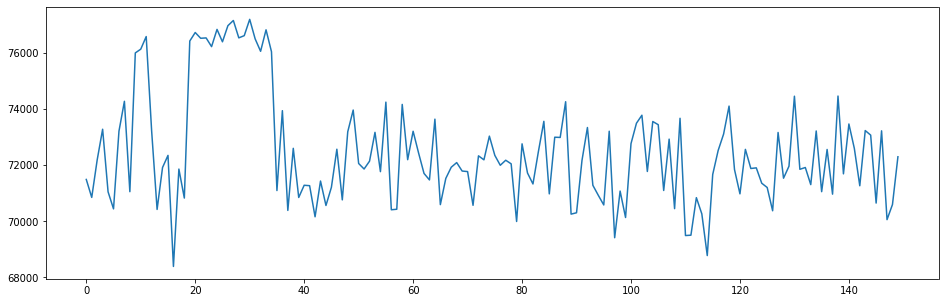

In [100]:
plt.figure(figsize=(16, 5))
plt.plot([i for i in range(0, len(deposit_dynamics_2))], deposit_dynamics_2)
plt.show()

## **ТЕСТИРОВАНИЕ**

**2017**

final #0	 reward = 14444.900	epsilon = 0.000
final #0	 deposit = 85621.900	epsilon = 0.000
[(1756, 3882.9, 'buy'), (1757, 3952.2000000000003, 'buy'), (1758, 3982.3, 'buy'), (1759, 3997.0, 'buy'), (1760, 3845.7999999999997, 'buy'), (1761, 3754.8, 'buy'), (1762, 3857.0, 'buy'), (1763, 3920.7, 'buy'), (1764, 3881.5, 'buy'), (1765, 3910.2, 'buy'), (1766, 3882.9, 'buy'), (1767, 3774.4, 'buy'), (1768, 3791.2, 'buy'), (1769, 3884.3, 'buy'), (1770, 3866.1, 'buy'), (1771, 3880.7999999999997, 'buy'), (1772, 3855.6, 'buy'), (1773, 3936.8, 'buy'), (2014, 4748.8, 'sell', 865.9000000000001), (2014, 4748.8, 'sell', 796.5999999999999), (2014, 4748.8, 'sell', 766.5), (2014, 4748.8, 'sell', 751.8000000000002), (2014, 4748.8, 'sell', 903.0000000000005), (2014, 4748.8, 'sell', 994.0), (2014, 4748.8, 'sell', 891.8000000000002), (2014, 4748.8, 'sell', 828.1000000000004), (2014, 4748.8, 'sell', 867.3000000000002), (2014, 4748.8, 'sell', 838.6000000000004), (2014, 4748.8, 'sell', 865.9000000000001), (2014, 47

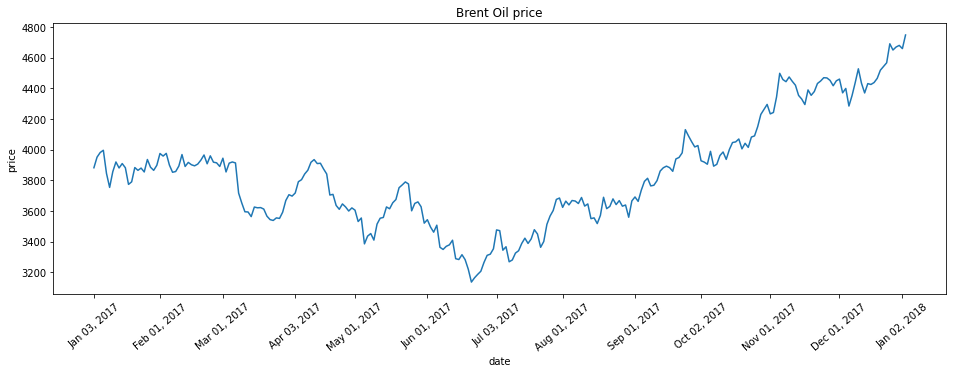

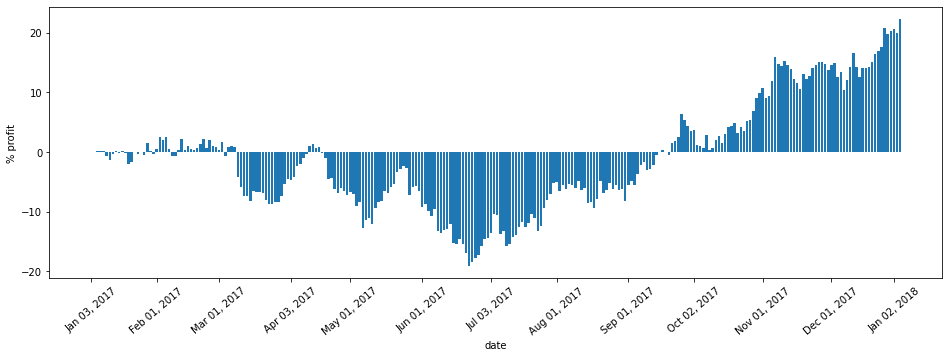

In [104]:
# 2017
test_start_index = 1756
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_2_2017 = trade_test(env_test, test_start_index, network_A_res_2, opt_A_res_2, network_B_res_2, opt_B_res_2)
deposits_evaluation_2_2017 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_2_2017]

x = [env_test.data.iloc[i]["Date"] for i in range(1756, 1756 + len(deposits_evaluation_2_2017))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_2_2017)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

**2015**

final #0	 reward = -18492.100	epsilon = 0.000
final #0	 deposit = 52672.900	epsilon = 0.000
[(1240, 3949.4, 'buy'), (1241, 3717.7, 'buy'), (1242, 3577.0, 'buy'), (1243, 3580.5, 'buy'), (1244, 3567.2000000000003, 'buy'), (1245, 3507.7, 'buy'), (1246, 3320.1, 'buy'), (1247, 3261.3, 'buy'), (1248, 3408.2999999999997, 'buy'), (1249, 3336.9, 'buy'), (1250, 3511.9, 'buy'), (1251, 3418.8, 'buy'), (1252, 3359.3, 'buy'), (1253, 3432.1, 'buy'), (1254, 3396.4, 'buy'), (1255, 3415.2999999999997, 'buy'), (1256, 3371.2, 'buy'), (1257, 3472.0, 'buy'), (1258, 3392.9, 'buy'), (1259, 3439.1000000000004, 'buy'), (1498, 2605.4, 'sell', -1344.0), (1498, 2605.4, 'sell', -1112.2999999999997), (1498, 2605.4, 'sell', -971.5999999999999), (1498, 2605.4, 'sell', -975.0999999999999), (1498, 2605.4, 'sell', -961.8000000000002), (1498, 2605.4, 'sell', -902.2999999999997), (1498, 2605.4, 'sell', -714.6999999999998), (1498, 2605.4, 'sell', -655.9000000000001), (1498, 2605.4, 'sell', -802.8999999999996), (1498, 2605.4

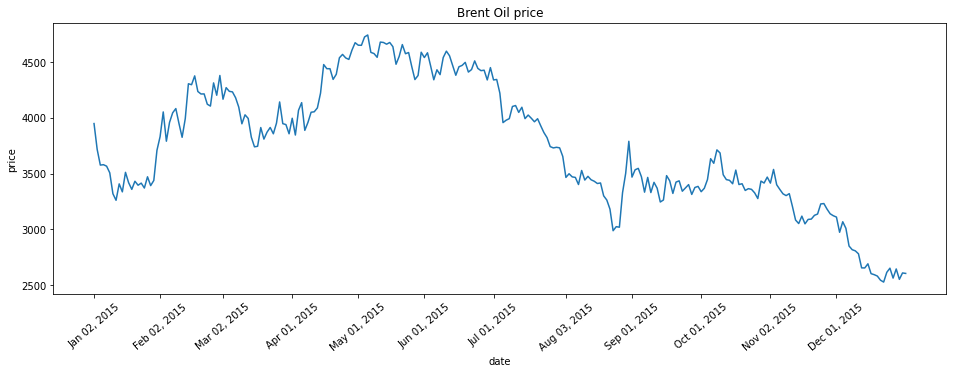

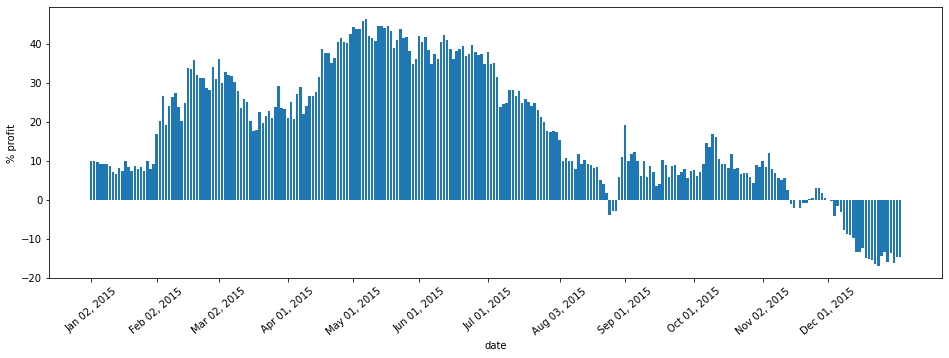

In [109]:
# 2015
test_start_index = 1240
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_2_2015 = trade_test(env_test, test_start_index, network_A_train_2, opt_A_train_2, network_B_train_2, opt_B_train_2)
deposits_evaluation_2_2015 = [(value - 70000) / 70000 * 100 + 10 for value in deposits_evaluation_test_2_2015]

x = [env_test.data.iloc[i]["Date"] for i in range(1240, 1240 + len(deposits_evaluation_2_2015))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_2_2015)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

# **ИСПЫТАНИЕ 3**

## **ТРЕНИРОВКА**

In [114]:
train_start_index = 2271
env_train = ExchangeEnv(start_index=train_start_index)

network_A_train_3 = LSTM(input_dim=6, hidden_dim=32, output_dim=3, num_layers=2)
opt_A_train_3 = torch.optim.Adam(network_A_train_3.parameters(), lr = 3 * 10**-4)

network_B_train_3 = None
opt_B_train_3 = None

session_dynamics_3, deposit_dynamics_3, network_A_res_3, opt_A_res_3, network_B_res_3, opt_B_res_3 = trade_train(env=env_train, 
                                                                                                                 start=train_start_index,
                                                                                                                 is_double=False,
                                                                                                                 network_A_train=network_A_train_3, 
                                                                                                                 opt_A_train=opt_A_train_3, 
                                                                                                                 network_B_par=network_B_train_3, 
                                                                                                                 opt_B_par=opt_B_train_3)

epoch #0	mean reward = 18021.680	epsilon = 0.500
epoch #0	mean deposit = 77453.320	epsilon = 0.500
min deposit eval =  63634.2
max deposit eval =  88514.29999999999
final deposits =  [75564.29999999999, 73084.9, 81945.50000000004, 85890.69999999998, 76371.4, 79352.00000000001, 74769.1, 77195.29999999999, 74321.79999999999, 76038.20000000001]
epoch #1	mean reward = 12677.420	epsilon = 0.485
epoch #1	mean deposit = 75574.380	epsilon = 0.485
min deposit eval =  63260.399999999994
max deposit eval =  86097.20000000001
final deposits =  [77322.0, 72584.4, 75681.20000000001, 77102.2, 75122.6, 75795.30000000002, 75162.5, 74806.19999999998, 75285.0, 76882.40000000001]
epoch #2	mean reward = 4951.730	epsilon = 0.470
epoch #2	mean deposit = 71602.790	epsilon = 0.470
min deposit eval =  68410.99999999999
max deposit eval =  82382.29999999996
final deposits =  [82189.09999999995, 68870.89999999995, 70120.39999999997, 71871.79999999999, 71457.39999999989, 70699.99999999993, 69202.70000000003, 70994

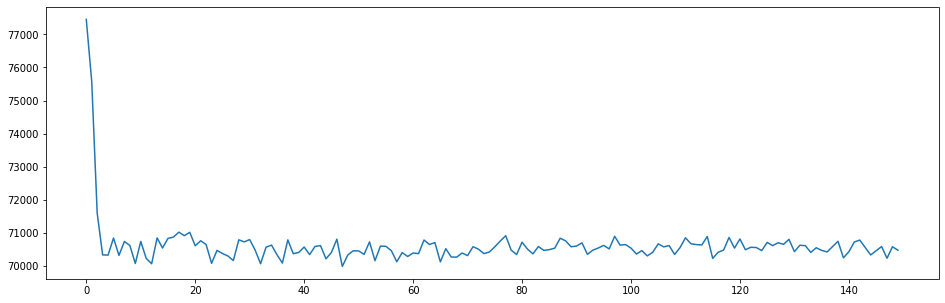

In [116]:
plt.figure(figsize=(16, 5))
plt.plot([i for i in range(0, len(deposit_dynamics_3))], deposit_dynamics_3)
plt.show()

## **ТЕСТИРОВАНИЕ**

**2017**

final #0	 reward = 3376.600	epsilon = 0.000
final #0	 deposit = 71082.200	epsilon = 0.000
[(1756, 3882.9, 'buy'), (1757, 3952.2000000000003, 'sell', 69.30000000000018), (1758, 3982.3, 'buy'), (1759, 3997.0, 'sell', 14.699999999999818), (1760, 3845.7999999999997, 'buy'), (1761, 3754.8, 'sell', -90.99999999999955), (1762, 3857.0, 'buy'), (1763, 3920.7, 'sell', 63.69999999999982), (1764, 3881.5, 'buy'), (1765, 3910.2, 'sell', 28.699999999999818), (1766, 3882.9, 'buy'), (1767, 3774.4, 'sell', -108.5), (1768, 3791.2, 'buy'), (1769, 3884.3, 'sell', 93.10000000000036), (1770, 3866.1, 'buy'), (1771, 3880.7999999999997, 'sell', 14.699999999999818), (1772, 3855.6, 'buy'), (1773, 3936.8, 'sell', 81.20000000000027), (1774, 3886.4, 'buy'), (1775, 3866.1, 'sell', -20.300000000000182), (1776, 3899.0, 'buy'), (1777, 3976.0, 'sell', 77.0), (1778, 3959.2000000000003, 'buy'), (1779, 3976.7000000000003, 'sell', 17.5), (1780, 3900.4, 'buy'), (1781, 3853.5, 'sell', -46.90000000000009), (1782, 3858.399999999

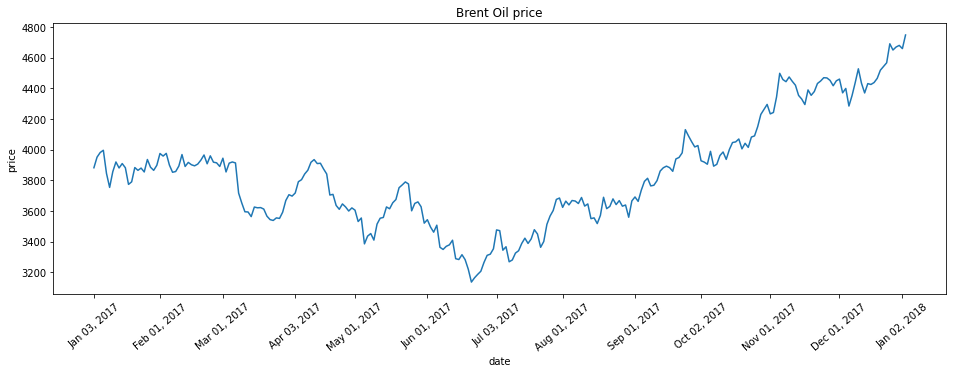

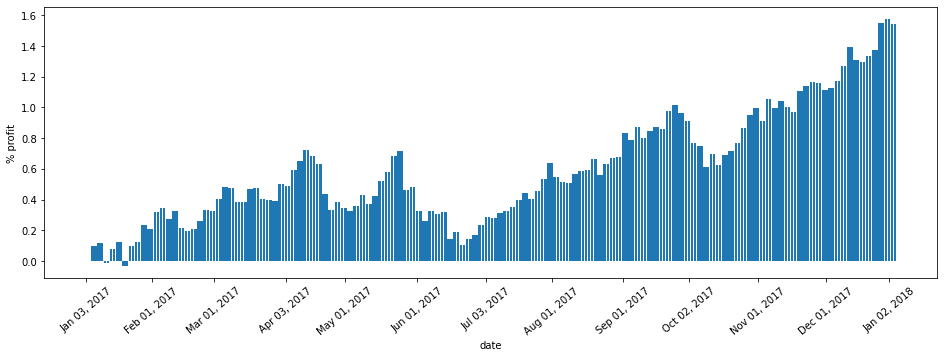

In [118]:
# 2017
test_start_index = 1756
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_3_2017 = trade_test(env_test, test_start_index, network_A_res_3, opt_A_res_3, network_B_res_3, opt_B_res_3)
deposits_evaluation_3_2017 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_3_2017]

x = [env_test.data.iloc[i]["Date"] for i in range(1756, 1756 + len(deposits_evaluation_3_2017))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_3_2017)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

final #0	 reward = -5859.200	epsilon = 0.000
final #0	 deposit = 68003.600	epsilon = 0.000
[(1240, 3949.4, 'buy'), (1241, 3717.7, 'sell', -231.70000000000027), (1242, 3577.0, 'buy'), (1243, 3580.5, 'sell', 3.5), (1244, 3567.2000000000003, 'buy'), (1245, 3507.7, 'sell', -59.500000000000455), (1246, 3320.1, 'buy'), (1247, 3261.3, 'sell', -58.79999999999973), (1248, 3408.2999999999997, 'buy'), (1249, 3336.9, 'sell', -71.39999999999964), (1250, 3511.9, 'buy'), (1251, 3418.8, 'sell', -93.09999999999991), (1252, 3359.3, 'buy'), (1253, 3432.1, 'sell', 72.79999999999973), (1254, 3396.4, 'buy'), (1255, 3415.2999999999997, 'sell', 18.899999999999636), (1256, 3371.2, 'buy'), (1257, 3472.0, 'sell', 100.80000000000018), (1258, 3392.9, 'buy'), (1259, 3439.1000000000004, 'sell', 46.20000000000027), (1260, 3709.3, 'buy'), (1261, 3832.5, 'sell', 123.19999999999982), (1262, 4053.7, 'buy'), (1263, 3791.2, 'sell', -262.5), (1264, 3959.9, 'buy'), (1265, 4046.0, 'sell', 86.09999999999991), (1266, 4083.8, 'b

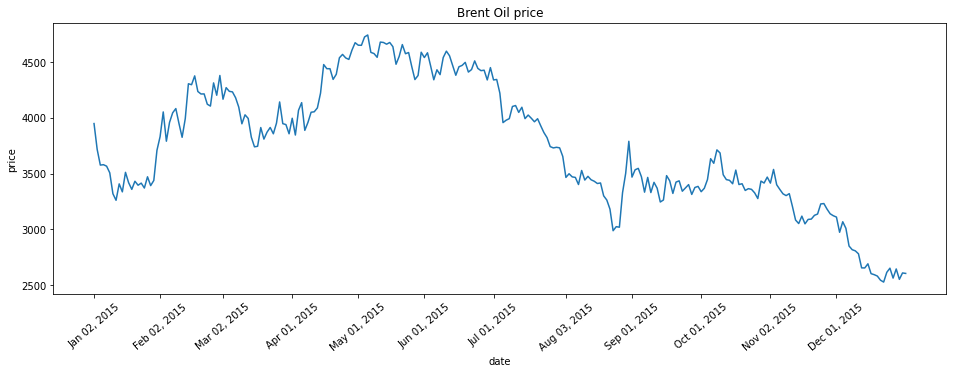

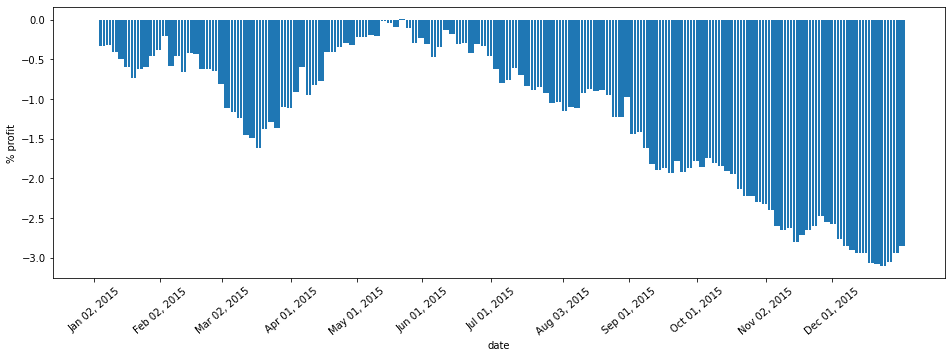

In [121]:
# 2015
test_start_index = 1240
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_3_2015 = trade_test(env_test, test_start_index, network_A_train_3, opt_A_train_3, network_B_train_3, opt_B_train_3)
deposits_evaluation_3_2015 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_3_2015]

x = [env_test.data.iloc[i]["Date"] for i in range(1240, 1240 + len(deposits_evaluation_3_2015))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_3_2015)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

# **ИСПЫТАНИЕ 4**

## **ТРЕНИРОВКА**

In [125]:
train_start_index = 2271
env_train = ExchangeEnv(start_index=train_start_index)

network_A_train_4 = DQN(6 * 4, 3)
opt_A_train_4 = torch.optim.Adam(network_A_train_4.parameters(), lr=3 * 10**-4)

network_B_train_4 = DQN(6 * 4, 3)
opt_B_train_4 = torch.optim.Adam(network_B_train_4.parameters(), lr=3 * 10**-4)

session_dynamics_4, deposit_dynamics_4, network_A_res_4, opt_A_res_4, network_B_res_4, opt_B_res_4 = trade_train(env=env_train, 
                                                                                                                 start=train_start_index,
                                                                                                                 is_double=True,
                                                                                                                 network_A_train=network_A_train_4, 
                                                                                                                 opt_A_train=opt_A_train_4, 
                                                                                                                 network_B_par=network_B_train_4, 
                                                                                                                 opt_B_par=opt_B_train_4)

epoch #0	mean reward = 992.730	epsilon = 0.500
epoch #0	mean deposit = 70756.490	epsilon = 0.500
min deposit eval =  60144.700000000004
max deposit eval =  78703.79999999997
final deposits =  [71732.50000000003, 75176.5, 70871.49999999991, 68177.90000000001, 69904.79999999996, 61018.3, 72735.59999999998, 70126.7, 72097.89999999998, 75723.20000000001]
epoch #1	mean reward = 305.010	epsilon = 0.485
epoch #1	mean deposit = 70398.370	epsilon = 0.485
min deposit eval =  58438.8
max deposit eval =  82565.0
final deposits =  [68246.50000000006, 66102.40000000001, 69048.0, 68385.10000000006, 74878.99999999997, 69103.3, 74256.70000000001, 72830.1, 72039.1, 69093.5]
epoch #2	mean reward = -4553.510	epsilon = 0.470
epoch #2	mean deposit = 68835.270	epsilon = 0.470
min deposit eval =  58942.79999999995
max deposit eval =  80083.5
final deposits =  [72551.49999999997, 73902.49999999997, 64013.59999999996, 73073.0, 67622.79999999996, 69869.09999999998, 70555.80000000002, 65625.00000000003, 64250.199

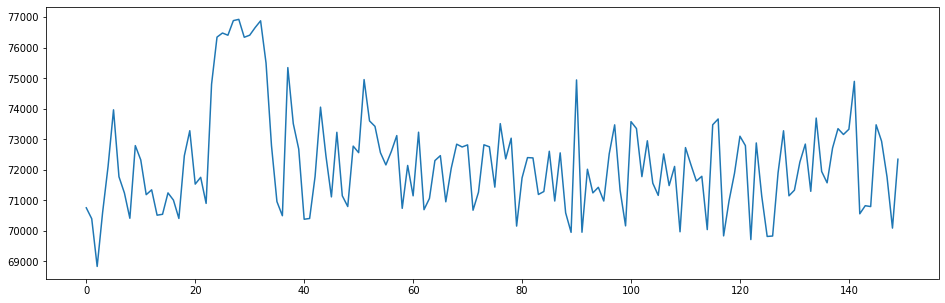

In [126]:
plt.figure(figsize=(16, 5))
plt.plot([i for i in range(0, len(deposit_dynamics_4))], deposit_dynamics_4)
plt.show()

## **ТЕСТИРОВАНИЕ**

**2017**

final #0	 reward = 14555.800	epsilon = 0.000
final #0	 deposit = 85640.800	epsilon = 0.000
[(1756, 3882.9, 'buy'), (1757, 3952.2000000000003, 'buy'), (1758, 3982.3, 'buy'), (1759, 3997.0, 'buy'), (1760, 3845.7999999999997, 'buy'), (1761, 3754.8, 'buy'), (1762, 3857.0, 'buy'), (1763, 3920.7, 'buy'), (1764, 3881.5, 'buy'), (1765, 3910.2, 'buy'), (1766, 3882.9, 'buy'), (1767, 3774.4, 'buy'), (1768, 3791.2, 'buy'), (1769, 3884.3, 'buy'), (1770, 3866.1, 'buy'), (1771, 3880.7999999999997, 'buy'), (1772, 3855.6, 'buy'), (1773, 3936.8, 'buy'), (1813, 3539.2000000000003, 'sell', -343.6999999999998), (1814, 3556.0, 'buy'), (1981, 4330.9, 'sell', 378.69999999999936), (1982, 4295.2, 'buy'), (2014, 4748.8, 'sell', 766.5), (2014, 4748.8, 'sell', 751.8000000000002), (2014, 4748.8, 'sell', 903.0000000000005), (2014, 4748.8, 'sell', 994.0), (2014, 4748.8, 'sell', 891.8000000000002), (2014, 4748.8, 'sell', 828.1000000000004), (2014, 4748.8, 'sell', 867.3000000000002), (2014, 4748.8, 'sell', 838.60000000

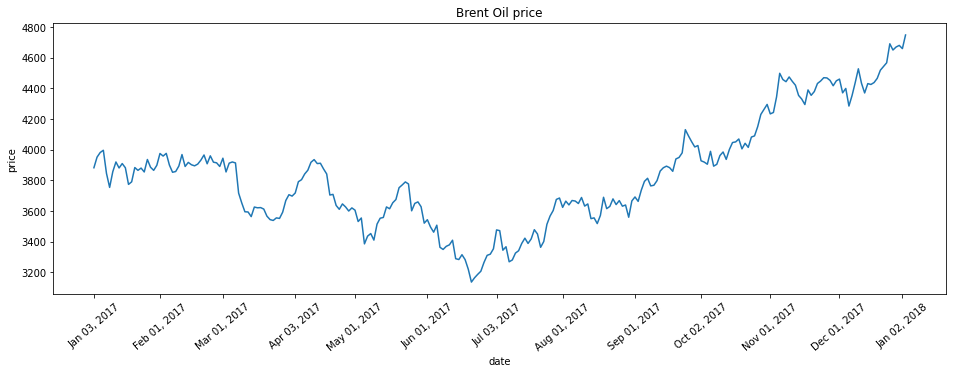

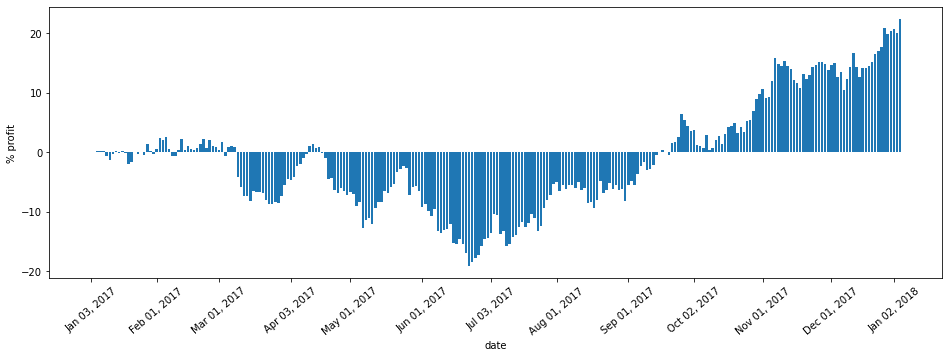

In [128]:
# 2017
test_start_index = 1756
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_4_2017 = trade_test(env_test, test_start_index, network_A_res_4, opt_A_res_4, network_B_res_4, opt_B_res_4)
deposits_evaluation_4_2017 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_4_2017]

x = [env_test.data.iloc[i]["Date"] for i in range(1756, 1756 + len(deposits_evaluation_4_2017))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_4_2017)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

**2015**

final #0	 reward = -17577.800	epsilon = 0.000
final #0	 deposit = 52138.800	epsilon = 0.000
[(1240, 3949.4, 'buy'), (1241, 3717.7, 'buy'), (1242, 3577.0, 'buy'), (1243, 3580.5, 'buy'), (1244, 3567.2000000000003, 'buy'), (1245, 3507.7, 'buy'), (1246, 3320.1, 'buy'), (1247, 3261.3, 'buy'), (1248, 3408.2999999999997, 'buy'), (1249, 3336.9, 'buy'), (1250, 3511.9, 'buy'), (1251, 3418.8, 'buy'), (1252, 3359.3, 'buy'), (1253, 3432.1, 'buy'), (1254, 3396.4, 'buy'), (1255, 3415.2999999999997, 'buy'), (1256, 3371.2, 'buy'), (1257, 3472.0, 'buy'), (1258, 3392.9, 'buy'), (1259, 3439.1000000000004, 'sell', -510.2999999999997), (1260, 3709.3, 'buy'), (1305, 4068.3999999999996, 'sell', 350.6999999999998), (1306, 4137.0, 'buy'), (1362, 4444.3, 'sell', 867.3000000000002), (1363, 4424.0, 'buy'), (1389, 3654.7000000000003, 'buy'), (1498, 2605.4, 'sell', -975.0999999999999), (1498, 2605.4, 'sell', -961.8000000000002), (1498, 2605.4, 'sell', -902.2999999999997), (1498, 2605.4, 'sell', -714.6999999999998), 

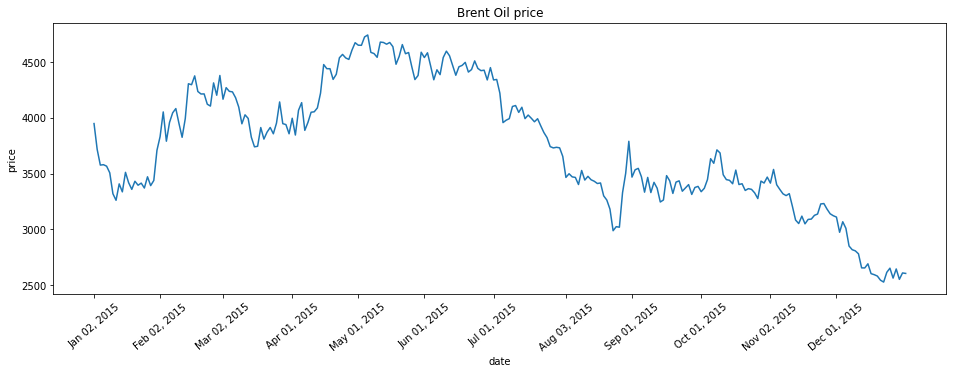

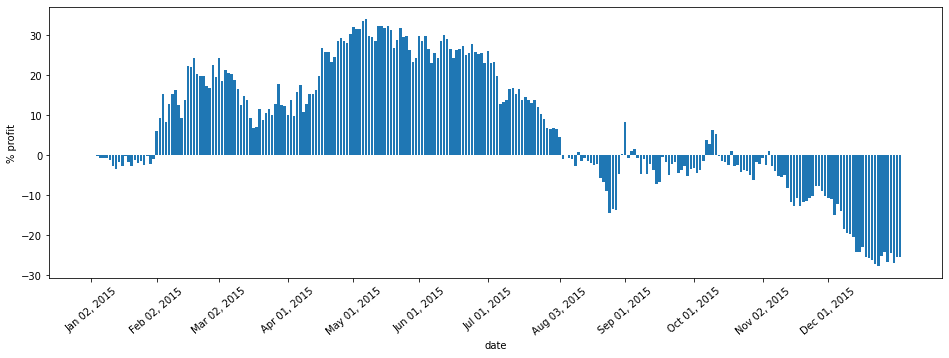

In [130]:
# 2015
test_start_index = 1240
env_test = ExchangeEnv(start_index=test_start_index)

deposits_evaluation_test_4_2015 = trade_test(env_test, test_start_index, network_A_train_4, opt_A_train_4, network_B_train_4, opt_B_train_4)
deposits_evaluation_4_2015 = [(value - 70000) / 70000 * 100 for value in deposits_evaluation_test_4_2015]

x = [env_test.data.iloc[i]["Date"] for i in range(1240, 1240 + len(deposits_evaluation_4_2015))]
plt.figure(figsize=(16, 5))
plt.bar(x, deposits_evaluation_4_2015)

ticks = []
added = False
for i in range(0, len(x)):
    if (x[i][4:6] == "01" or x[i][4:6] == "02" or x[i][4:6] == "03") and not added:
        ticks.append(x[i])
        added = True
    elif x[i][4:6] == "05" or x[i][4:6] == "06" or x[i][4:6] == "07":
        added = False
plt.xticks(ticks, rotation=40)

plt.xlabel("date")
plt.ylabel("% profit")

plt.show()

In [136]:
# Save_1
torch.save(network_A_train_1, "/content/gdrive/MyDrive/Colab Notebooks/network_A_train_1.pt")
torch.save(network_B_train_1, "/content/gdrive/MyDrive/Colab Notebooks/network_B_train_1.pt")

In [132]:
# Save_2
torch.save(network_A_train_2, "/content/gdrive/MyDrive/Colab Notebooks/network_A_train_2.pt")
torch.save(network_B_train_2, "/content/gdrive/MyDrive/Colab Notebooks/network_B_train_2.pt")

In [133]:
# Save_3
torch.save(network_A_train_3, "/content/gdrive/MyDrive/Colab Notebooks/network_A_train_3.pt")
torch.save(network_B_train_3, "/content/gdrive/MyDrive/Colab Notebooks/network_B_train_3.pt")

In [134]:
# Save_4
torch.save(network_A_train_4, "/content/gdrive/MyDrive/Colab Notebooks/network_A_train_4.pt")
torch.save(network_B_train_4, "/content/gdrive/MyDrive/Colab Notebooks/network_B_train_4.pt")